In [22]:
import os
import re

import ase
from ase.visualize import view
import numpy as np
import jax
import jax.numpy as jnp
import tensorflow as tf
import matplotlib.pyplot as plt

import ml_collections

from molnet.data import input_pipeline_online
from configs import root_dirs
from configs.tests import attention_test

In [23]:
config = attention_test.get_config()
config.train_molecules = (0, 1024)
config.val_molecules = (0, 1024)
config.rng_seed = 0
config.root_dir = root_dirs.get_root_dir()
config.num_workers = 8
config.batch_size = 1

In [42]:
tf.random.set_seed(config.rng_seed)
datasets = input_pipeline_online.get_datasets(config)

ds = iter(datasets['val'])
batch = next(ds)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8541915143570342263
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8541915143570342263


In [43]:
x = batch['images'][0]
y = batch['atom_map'][0]
xyz = batch['xyz'][0]
sw = batch['sw'][0]

print(xyz[:, -1])
print(x.shape, y.shape, xyz.shape)
print(f"ymin, ymax: {y.min()}, {y.max()}")
print(sw)
print(xyz)

[9. 8. 7. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(128, 128, 20, 1) (128, 128, 20, 5) (54, 5)
ymin, ymax: 0.0, 0.9937516450881958
[[ 0.         0.         0.       ]
 [15.9       15.9        1.9000001]]
[[ 8.95812416e+00  3.49529409e+00 -1.76827516e-02 -1.62959993e-01
   9.00000000e+00]
 [ 7.98849344e+00  7.60449219e+00 -4.62181953e-04 -2.56339997e-01
   8.00000000e+00]
 [ 9.70908546e+00  6.17774105e+00 -4.36305115e-03 -2.34899998e-01
   7.00000000e+00]
 [ 8.81049347e+00  1.26206713e+01  2.03482080e-02 -1.20599996e-02
   6.00000000e+00]
 [ 5.34360313e+00  3.30256224e+00 -1.90980583e-02  3.65000009e-03
   6.00000000e+00]
 [ 7.65850735e+00  1.18289719e+01  1.53817097e-02  2.85999989e-03
   6.00000000e+00]
 [ 1.00682688e+01  1.20065794e+01  1.96638070e-02  3.70000000e-03
   6.00000000e+00]
 [ 6.68695164e+00  2.92288017e+00 -2.06838176e-02 -2.60300003e-02
   6.00000000e+00]
 

0.99375165 0.0


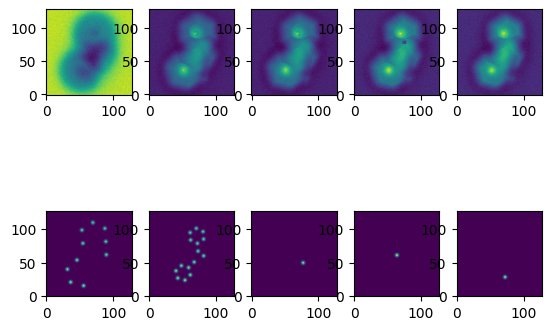

In [44]:
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x[..., -i, 0], origin='lower')

ymax, ymin = y.max(), y.min()
for i in range(5):
    ax = plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(y[..., i].sum(axis=-1), origin='lower')

print(ymax, ymin)

ymin, ymax: 0.0, 0.9937516450881958


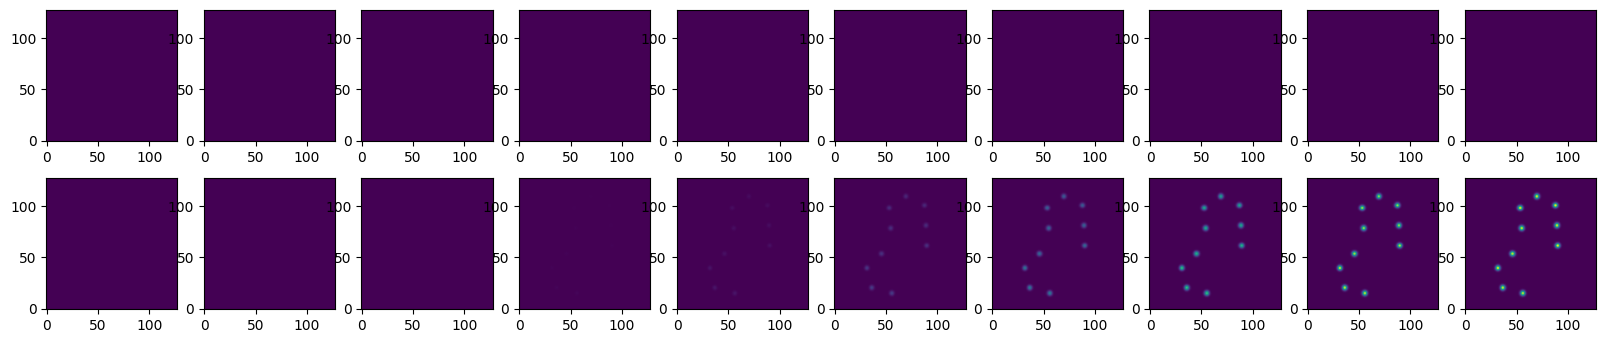

In [47]:
# Plot entire stack of y[..., -1]
channel = 0
ymin, ymax = y.min(), y.max()
print(f"ymin, ymax: {ymin}, {ymax}")

fig = plt.figure(figsize=(20, 4))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    im = plt.imshow(y[..., i, channel], origin='lower', vmin=ymin, vmax=ymax)


In [18]:
mol = ase.Atoms(positions=xyz[:, :3], numbers=xyz[:, -1].astype(int))
view(mol)

<Popen: returncode: None args: ['/Users/kurkil1/.venvs/tf-2.13/bin/python', ...>

## Create "fake" webdataset for testing

In [ ]:
import webdataset as wds

In [ ]:
def generator(N=100):
    for i in range(N):
        sample = {
            "__key__": str(i*100),
            "label.cls": i*100,
        }
        yield sample

In [ ]:
temp_outputdir = "./temp/shard_1.tar"

os.makedirs(os.path.dirname(temp_outputdir), exist_ok=True)

gen = generator(100)
with wds.TarWriter(temp_outputdir) as sink:
    for sample in gen:
        sink.write(sample)

In [ ]:
shardlist = [
    os.path.join("./temp", shard) for shard in os.listdir("./temp")
]
ds = wds.DataPipeline(
    wds.SimpleShardList(shardlist),

    wds.shuffle(100),

    wds.tarfile_to_samples(),

    wds.shuffle(1000),

    wds.decode("l"),

    wds.to_tuple("__key__", "label.cls"),

    wds.batched(16)
)

In [ ]:
loader = iter(ds)
end_after_this_iteration = False

for i in range(1000):
    try:
        batch = next(loader)
    except StopIteration:
        if end_after_this_iteration:
            break
        print()

        loader = iter(ds)
        end_after_this_iteration = True
        continue

    print(batch[0])

['8900', '2100', '2000', '7300', '1', '6000', '6700', '400', '2800', '3', '1000', '12', '10', '7600', '2500', '27']
['3000', '6600', '22', '2300', '23', '31', '5600', '15', '24', '7700', '9100', '9', '7000', '18', '7800', '9500']
['1900', '46', '66', '3300', '62', '11', '72', '71', '36', '6800', '57', '33', '4600', '7', '4400', '8100']
['9800', '14', '8800', '5700', '1800', '3700', '47', '2600', '600', '6100', '2700', '21', '97', '43', '68', '7200']
['5800', '800', '3900', '8400', '80', '1600', '83', '51', '37', '7400', '6900', '1700', '4900', '87', '1300', '63']
['4300', '30', '9200', '2', '94', '9000', '8700', '95', '52', '7100', '2900', '38', '4', '300', '3600', '73']
['1200', '45', '6200', '100', '39', '49', '13', '4200', '65', '2200', '4500', '85', '5', '7900', '40', '8200']
['86', '9600', '61', '55', '4700', '89', '8600', '19', '76', '77', '3100', '75', '17', '48', '4000', '9900']
['6500', '5200', '8500', '4800', '29', '5900', '69', '34', '3200', '32', '58', '70', '7500', '0', '3

## test tf atom map computation

In [31]:
def compute_map(xyz, sigma=0.2):
    x = tf.linspace(tf.constant(0, dtype=tf.float32), 16, 128)
    y = tf.linspace(tf.constant(0, dtype=tf.float32), 16, 128)
    z = tf.range(14, 16, 0.1, dtype=tf.float32)

    X, Y, Z = tf.meshgrid(x, y, z, indexing='xy')

    # Compute atom maps.
    maps_h = tf.zeros_like(X)
    maps_c = tf.zeros_like(X)
    maps_n = tf.zeros_like(X)
    maps_o = tf.zeros_like(X)
    maps_f = tf.zeros_like(X)

    for atom in xyz:
        if atom[-1] == 1:
            maps_h += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 6:
            maps_c += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 7:
            maps_n += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 8:
            maps_o += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )
        elif atom[-1] == 9:
            maps_f += tf.exp(
                -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2 * sigma**2)
            )

    atom_map = tf.stack([maps_h, maps_c, maps_n, maps_o, maps_f], axis=0)
    atom_map = tf.transpose(atom_map, perm=[1, 2, 3, 0])
    return atom_map


In [32]:
xyz = tf.random.uniform((xyz.shape[0], 3), 0, 16)
species = tf.random.uniform(xyz.shape, 6, 10, dtype=tf.int32)
species = tf.cast(species, tf.float32)[:,0][..., None]
xyz = tf.concat([xyz, species], axis=-1)

m = compute_map(xyz)

(128, 128, 20, 5)


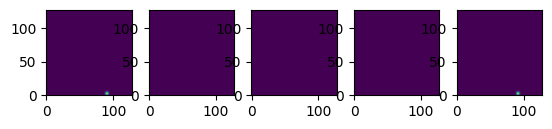

In [36]:
print(m.shape)

for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(m[..., -i, -1], origin='lower')

## data augmentation

In [2]:
def plot_stack(x):
    xmax = tf.reduce_max(x).numpy()
    fig, ax = plt.subplots(1, 5)
    for i in range(5):
        ax[i].imshow(x[..., i, 0], vmin=0, vmax=xmax)

In [6]:
x = np.arange(128)
y = np.arange(128)

x, y = np.meshgrid(x, y)
z = x + y
z = z[..., None]
z = np.tile(z, (1, 1, 5))

z2 = x * y
z2 = z2[None, ..., None]
z2 = np.tile(z2, (5, 1, 1, 20))

orig_batch = {
    "images": z,
    "atom_map": z2,
    "xyz": np.zeros((5, 20, 3)),
}

print(orig_batch['images'].shape)
print(orig_batch['atom_map'].shape)

(128, 128, 5)
(5, 128, 128, 20)


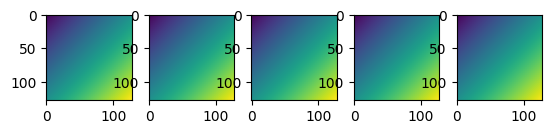

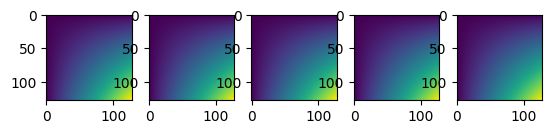

In [7]:
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z[..., i])

fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(z2[i, ..., 0])

In [16]:
print(orig_batch['images'].shape)

batch = input_pipeline._preprocess_images(
    orig_batch,
    noise_std=0.1,
    interpolate_z=16,
    cutout_probs=[0.5, 0.3, 0.1, 0.05, 0.5],
)

print(orig_batch['images'].shape)

print(batch['images'].shape)
print(batch['atom_map'].shape)

(128, 128, 5)
(128, 128, 5)
(128, 128, 16, 1)
(128, 128, 16, 5)


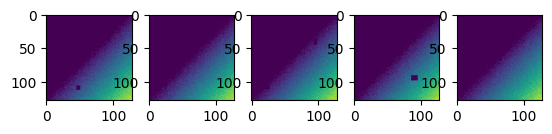

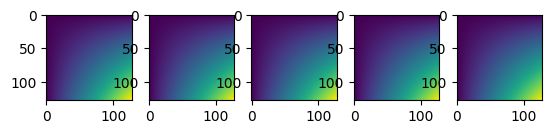

In [17]:
plot_stack(batch['images'])
plot_stack(batch['atom_map'])